- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
from glob import glob
import os
import sys

p = os.path.abspath('..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 현재 폴더에 추가된 모듈.

import torchvision.models as models


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.0  Device :  cuda


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [2]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

In [3]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology_sig=[]
healthy_sig=[]

pathology=[]
healthy=[]


#PATHOLOGY DATA
for audio_path in os.listdir('../../voice_data/pathology_new/u/export'):
    sig, sr = librosa.load('../../voice_data/pathology_new/u/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    pathology_sig.append(sig)
    MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    pathology.append(MFCCs)
    

#Healthy data
for audio_path in os.listdir('../../voice_data/healthy_new/u/export'):
    sig, sr = librosa.load('../../voice_data/healthy_new/u/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    healthy_sig.append(sig)
    MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
    healthy.append(MFCCs)
    
print("pathology data 수 : ",len(pathology))
print("healthy data 수 : ",len(healthy))


path_max=max([ len(samples) for samples in pathology_sig])
healthy_max=max([ len(samples) for samples in healthy_sig])
print("가장 긴 path sample :" ,path_max)
print("가장 긴 healthy sample :" ,healthy_max)

pathology data 수 :  1195
healthy data 수 :  687
가장 긴 path sample : 130793
가장 긴 healthy sample : 194501


In [4]:
print(path_max/sr,"초")
print(healthy_max/sr,"초")

2.61586 초
3.89002 초


In [5]:
print('평균 : ',np.mean([ len(samples) for samples in pathology_sig])/sr)
print('평균 : ',np.mean([ len(samples) for samples in healthy_sig])/sr)

평균 :  1.2356882510460252
평균 :  1.3178440174672488


In [6]:
400*313/sr
#400 frame은 약 2.5초 이상.

2.504

# 결과 확인
- 1 row당 1 frame으로

In [7]:
len(healthy[0][2]) #1번 : 파일. 2번:mfcc
headers = "mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6 mfcc7 mfcc8 mfcc9 mfcc10 mfcc11 mfcc12 mfcc13".split()
pd.DataFrame(healthy[1].T,columns=headers)



,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13
0,-272.275146,208.902557,44.434441,40.349213,-25.458517,12.826863,-3.920654,-8.411410,3.417778,7.566922,-2.498518,-6.284049,-2.326992
1,-292.371613,203.497162,55.854485,54.128845,-19.807659,14.410148,-1.129526,-7.547229,2.966858,11.841558,1.122357,-0.466148,-0.014877
2,-326.458984,179.993637,64.711746,65.344246,-17.435101,19.880333,2.197647,-1.880868,-4.580058,4.086713,3.976766,1.293952,6.717286
3,-324.657288,174.853928,61.641129,64.695351,-10.726300,23.473757,-8.347025,-9.129495,-7.556191,10.262231,8.042992,2.768127,9.962308
4,-317.942169,182.751175,64.051483,59.415588,-17.222746,18.475574,-8.616613,-10.723660,-0.691800,12.757200,7.716760,2.235234,4.562744
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,-354.029236,172.662659,72.229408,51.822090,-19.475491,24.674398,-14.183729,-14.277061,-8.532803,3.395573,14.948679,-4.153752,7.948050
337,-363.935699,166.532837,73.193100,50.661980,-21.652119,21.548904,-14.202366,-13.243938,-2.112081,3.580634,10.965590,-10.593177,3.021251
338,-364.039581,163.347534,80.410004,55.608833,-18.868038,21.568939,-14.416084,-12.026213,-2.639414,5.210083,14.799844,-4.204784,2.161280
339,-360.334564,167.725281,81.819809,53.282486,-13.211727,18.665279,-17.974466,-14.677999,-6.362213,-0.718999,20.342644,-3.675610,-3.875287


In [8]:
healthy[0].shape[1]

312

In [8]:
del pathology
del healthy
del pathology_sig
del healthy_sig

# 데이터 나누기 - Stratified KFold

- pathology : 1195 / healthy : 687 / 총 1882
- k = 5
- random over sampling 추가 ( healthy 데이터가 부족하기 때문)
- 변경 후 -> pathology : 1195 / healthy : 1195 / 총: 2390

kfold와 random over sampling을 같이 실시하려면, 미리 test set을 나눠야 한다.

먼저 테스트셋을 나누고, 그 후에 random over sampling을 실시한다

## 1. test/ train 나누기

- train+valid :1504  / test : 377


In [9]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

pathology = glob('../../voice_data/pathology_new/u/export/*.wav')
healthy = glob('../../voice_data/healthy_new/u/export/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<1195:
        Y.append("pathology")
    else:
        Y.append("healthy")

#train 1504   test: 377
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")



Pathology :  1195
Healthy:  687
총 데이터수 :  1882
---
훈련 셋 :  1505 Counter({'pathology': 956, 'healthy': 549})
테스트 셋 :  377 Counter({'pathology': 239, 'healthy': 138})
---


## 2. random over sampling

In [10]:

X = np.array(X).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
#Y = np.array(Y)
ros = RandomOverSampler(random_state = 123)
X_res,Y_res = ros.fit_resample(X,Y)

print('before dataset shape {}'.format(Counter(Y)) )
print('Resampled dataset shape {}'.format(Counter(Y_res)) )



before dataset shape Counter({'pathology': 956, 'healthy': 549})
Resampled dataset shape Counter({'healthy': 956, 'pathology': 956})


In [5]:
X_res

array([['../../voice_data/healthy_new/a/export\\60-a_n.wav'],
       ['../../voice_data/pathology_new/a/export\\2421-a_n.wav'],
       ['../../voice_data/pathology_new/a/export\\1270-a_n.wav'],
       ...,
       ['../../voice_data/healthy_new/a/export\\1127-a_n.wav'],
       ['../../voice_data/healthy_new/a/export\\1533-a_n.wav'],
       ['../../voice_data/healthy_new/a/export\\1359-a_n.wav']],
      dtype='<U52')

In [11]:
#원래대로 돌리기
X=X_res.reshape(1, -1)
print( '총 데이터수 : ',X[0].size )
print(  '복사된 수 : ',X[0].size - np.unique(X[0]).size )

X=X[0].tolist()
Y=Y_res

총 데이터수 :  1912
복사된 수 :  407


## 3. stratified k-fold

In [12]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 764, 'pathology': 765}
검증 레이블 데이터 분포 : 
 {'healthy': 192, 'pathology': 191} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 765, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 192} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 765, 'pathology': 765}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 191} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 765, 'pathology': 765}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 191} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 765, 'pathology': 765}
검증 레이블 데이터 분포 : 
 {'healthy': 191, 'pathology': 191} 



# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.
- 전처리 방법 결정.


In [13]:
from torch.utils.data import Dataset, DataLoader

classes = ["pathology","healthy"]
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 500프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig, sr = librosa.load(self.path_list[idx], sr=50000)# 논문에서 f_s = 50 000HZ
        
        MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
        #mfcc 400 FRAME이 되도록 패딩.
        length = 400
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        MFCCs = pad2d(MFCCs, length)
        MFCCs= MFCCs.T
        
        if self.transform:
            #print('transform')
            MFCCs=self.transform(MFCCs).type(torch.float32)# 데이터 0~1 정규화
            MFCCs=torch.stack([MFCCs,MFCCs,MFCCs])# 3채널로 복사.
            MFCCs = MFCCs.squeeze(dim=1)
        else:
            #print("else")
            MFCCs = torch.from_numpy(MFCCs).type(torch.float32)
            MFCCs=MFCCs.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MFCCs, self.classes.index(self.label[idx])
    

In [14]:
# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 500프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        sig, sr = librosa.load(self.path_list[idx], sr=50000)# 논문에서 f_s = 50 000HZ
        
        MFCCs = librosa.feature.mfcc(sig, sr, win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
        #mfcc 400 FRAME이 되도록 패딩.
        length = 400
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        MFCCs = pad2d(MFCCs, length)
        MFCCs= MFCCs.T
        
        if self.transform:
            #print('transform')
            MFCCs=self.transform(MFCCs).type(torch.float32)# 데이터 0~1 정규화
            MFCCs=torch.stack([MFCCs,MFCCs,MFCCs])# 3채널로 복사.
            MFCCs = MFCCs.squeeze(dim=1)
        else:
            #print("else")
            MFCCs = torch.from_numpy(MFCCs).type(torch.float32)
            MFCCs=MFCCs.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MFCCs, self.classes.index(self.label[idx])
    

# 데이터 로더

In [15]:
#3. 하이퍼 파라미터
BATCH_SIZE =  30 #한 배치당 30개 음성데이터 # 32 배수시에, 1개만 남는 경우가 발생해서.
EPOCHS = 40 # 전체 데이터 셋을 40번 반복

In [16]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [17]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# 데이터 확인

X_train :  torch.Size([30, 3, 400, 13]) type: torch.FloatTensor
Y_train :  torch.Size([30]) type: torch.LongTensor
tensor(0)


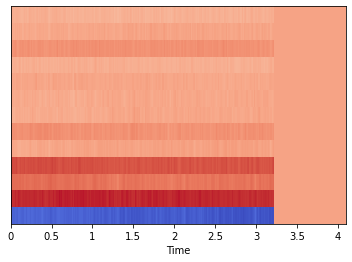

In [18]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
librosa.display.specshow(X_train[0][0].numpy().T, sr=50000, x_axis='time')
#batch: 32 / frame수: 400  /  feature수: 13

X_valid :  torch.Size([30, 3, 400, 13]) type: torch.FloatTensor
Y_valid :  torch.Size([30]) type: torch.LongTensor
tensor(1)


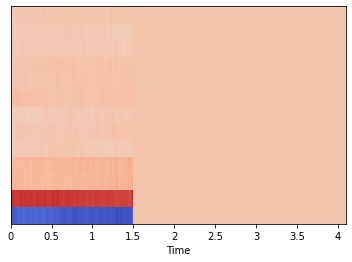

In [19]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0])
librosa.display.specshow(X_valid[0][0].numpy().T, sr=50000, x_axis='time')
#batch: 32 / 3채널 / frame수: 400  /  feature수: 13

X_valid :  torch.Size([30, 3, 400, 13]) type: torch.FloatTensor
Y_valid :  torch.Size([30]) type: torch.LongTensor
tensor(1)


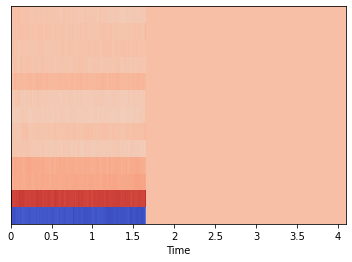

In [20]:
#test set 확인
for (test_data,test_label) in test_loader:
    print("X_valid : ",test_data.size(),'type:',test_data.type())
    print("Y_valid : ",test_label.size(),'type:',test_label.type())
    break

print(Y_valid[0])
librosa.display.specshow(test_data[0][0].numpy().T, sr=50000, x_axis='time')
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# RESNET18

In [21]:
# 모델 
# pretrained


def model_initialize():
    model = models.resnet18(pretrained=True).cuda()
    model.ftrs = model.fc.in_features # in_features : fully connected의 입력수.
    num_ftrs = model.fc.in_features

    model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                             nn.BatchNorm1d(256),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(256,128),
                             nn.BatchNorm1d(128),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(128,64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )

    model = model.cuda()
    return model
model=model_initialize()


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# get the model summary
from torchsummary import summary
summary(model, input_size=(3, 400, 13), device=DEVICE.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 200, 7]           9,408
       BatchNorm2d-2           [-1, 64, 200, 7]             128
              ReLU-3           [-1, 64, 200, 7]               0
         MaxPool2d-4           [-1, 64, 100, 4]               0
            Conv2d-5           [-1, 64, 100, 4]          36,864
       BatchNorm2d-6           [-1, 64, 100, 4]             128
              ReLU-7           [-1, 64, 100, 4]               0
            Conv2d-8           [-1, 64, 100, 4]          36,864
       BatchNorm2d-9           [-1, 64, 100, 4]             128
             ReLU-10           [-1, 64, 100, 4]               0
       BasicBlock-11           [-1, 64, 100, 4]               0
           Conv2d-12           [-1, 64, 100, 4]          36,864
      BatchNorm2d-13           [-1, 64, 100, 4]             128
             ReLU-14           [-1, 64,

In [24]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [25]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [26]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    
    return train_loader,validation_loader



In [27]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../checkpoint/checkpoint_resnet18_true_'+str(data_ind)+'_u.pt'

    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)

[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0260	 Train Acc:52.13 %  | 	Valid Loss:0.0235 	Valid Acc: 51.17 %

Validation loss decreased (inf --> 0.023514).  Saving model ...

[EPOCH:2]	 Train Loss:0.0260	 Train Acc:50.43 %  | 	Valid Loss:0.0232 	Valid Acc: 55.61 %

Validation loss decreased (0.023514 --> 0.023165).  Saving model ...

[EPOCH:3]	 Train Loss:0.0246	 Train Acc:52.45 %  | 	Valid Loss:0.0231 	Valid Acc: 56.14 %

Validation loss decreased (0.023165 --> 0.023135).  Saving model ...

[EPOCH:4]	 Train Loss:0.0243	 Train Acc:51.80 %  | 	Valid Loss:0.0231 	Valid Acc: 57.96 %

Validation loss decreased (0.023135 --> 0.023060).  Saving model ...

[EPOCH:5]	 Train Loss:0.0240	 Train Acc:51.93 %  | 	Valid Loss:0.0223 	Valid Acc: 61.10 %

Validation loss decreased (0.023060 --> 0.022343).  Saving model ...

[EPOCH:6]	 Train Loss:0.0226	 Train Acc:56.90 %  | 	Valid Loss:0.0217 	Valid Acc: 66.58 %

Validation loss decreased (0.022343 --> 0.021721).  Saving model ...

[EPOCH:7]	 Trai


[EPOCH:29]	 Train Loss:0.0136	 Train Acc:84.04 %  | 	Valid Loss:0.0195 	Valid Acc: 71.54 %

EarlyStopping counter: 4 out of 5

[EPOCH:30]	 Train Loss:0.0126	 Train Acc:84.37 %  | 	Valid Loss:0.0182 	Valid Acc: 73.89 %

Validation loss decreased (0.018405 --> 0.018151).  Saving model ...

[EPOCH:31]	 Train Loss:0.0113	 Train Acc:87.25 %  | 	Valid Loss:0.0168 	Valid Acc: 77.28 %

Validation loss decreased (0.018151 --> 0.016766).  Saving model ...

[EPOCH:32]	 Train Loss:0.0098	 Train Acc:90.97 %  | 	Valid Loss:0.0180 	Valid Acc: 73.37 %

EarlyStopping counter: 1 out of 5

[EPOCH:33]	 Train Loss:0.0090	 Train Acc:92.87 %  | 	Valid Loss:0.0185 	Valid Acc: 74.67 %

EarlyStopping counter: 2 out of 5

[EPOCH:34]	 Train Loss:0.0088	 Train Acc:91.96 %  | 	Valid Loss:0.0163 	Valid Acc: 77.55 %

Validation loss decreased (0.016766 --> 0.016289).  Saving model ...

[EPOCH:35]	 Train Loss:0.0073	 Train Acc:94.57 %  | 	Valid Loss:0.0178 	Valid Acc: 77.81 %

EarlyStopping counter: 1 out of 5

[EPOC

# 모델 결과 확인

In [28]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 85.5461 |	 valid ACC: 77.2846 
[2 교차검증] train ACC : 91.9555 |	 valid ACC: 77.5457 
[3 교차검증] train ACC : 91.8301 |	 valid ACC: 76.9634 
[4 교차검증] train ACC : 56.7320 |	 valid ACC: 62.3037 
[5 교차검증] train ACC : 51.3072 |	 valid ACC: 61.2565 
평균 검증 정확도 71.0707694831381 %


# Model Test

- test set
- confusion matrix

In [29]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [30]:

# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0

for data_ind in range(1,6):

    check_path = '../checkpoint/checkpoint_resnet18_true_'+str(data_ind)+'_u.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    fscore=2*precision*recall/(precision+recall)
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))



1번 모델
Accuracy : 67.1088% 
Precision (pathology 예측한 것중 맞는 것) : 0.7778
recall (실제 pathology 중  예측이 맞는 것) : 0.6736
f score : 0.7220 
[[161  78]
 [ 46  92]]
-----
2번 모델
Accuracy : 64.7215% 
Precision (pathology 예측한 것중 맞는 것) : 0.7325
recall (실제 pathology 중  예측이 맞는 것) : 0.6987
f score : 0.7152 
[[167  72]
 [ 61  77]]
-----
3번 모델
Accuracy : 62.3342% 
Precision (pathology 예측한 것중 맞는 것) : 0.7215
recall (실제 pathology 중  예측이 맞는 것) : 0.6611
f score : 0.6900 
[[158  81]
 [ 61  77]]
-----
4번 모델
Accuracy : 63.6605% 
Precision (pathology 예측한 것중 맞는 것) : 0.6977
recall (실제 pathology 중  예측이 맞는 것) : 0.7531
f score : 0.7243 
[[180  59]
 [ 78  60]]
-----
5번 모델
Accuracy : 65.7825% 
Precision (pathology 예측한 것중 맞는 것) : 0.7022
recall (실제 pathology 중  예측이 맞는 것) : 0.7992
f score : 0.7476 
[[191  48]
 [ 81  57]]
-----
평균 acc : 0.6472
